In [1]:
chrom = '1'

In [2]:
segment_length = 64
remove_diagonal = True

config_fp = '../../data/processed_data.hdf5'
embedding_dir = '../../data/embeddings_64_after_transformer/'
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

#### Support functions

In [3]:
import torch
import sys
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1,'../data_utils/')
from Sample import Sample
from OrigamiTransform import OrigamiTransform
origami_transform = OrigamiTransform()

In [4]:
def is_square(mat):
    s = mat.shape
    assert len(s) > 1, f'Tensor must have at least two dimensions. Provided shape: {s}'
    return s[-1] == s[-2]

def copy_matrix_elements(from_mat,to_mat):
    assert is_square(from_mat) and is_square(to_mat), f'Both matrices must be square in the final two dimensions'

    n1,n2= from_mat.shape[-1],to_mat.shape[-1]
    n,N = min(n1,n2),max(n1,n2)

    i,j = torch.triu_indices(n,n,0)

    shift1,shift2 = max(0,n1-n2),max(0,n2-n1)
    to_mat[...,i,shift2+j] = from_mat[...,i,shift1+j]
    to_mat[...,shift2+j,i] = from_mat[...,shift1+j,i]
    

def add_diagonal(mat,diag_value=0):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'
    
    N = mat.shape[-1] + 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    i = torch.arange(N)
    new_mat[...,i,i] = diag_value

    return new_mat

def remove_diagonal(mat):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'

    N = mat.shape[-1] - 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    
    return new_mat

In [80]:
import torch
from tensor_support import remove_diagonal

def distance_hist(exp_data,gen_data,**kwargs):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(gen_data.flatten().cpu().numpy(),alpha=0.5,label='Generated',density=True,**kwargs)
    ax.hist(exp_data.flatten().cpu().numpy(),alpha=0.5,label='Experimental',density=True,**kwargs)
    ax.legend()

    return fig,ax

def is_int(x):
    return int(x) == x

class DistanceCompare: 

    def __init__(self,config_dataset,sample=None,indices=None,device=None):

        self.exp_ds = config_dataset
        self.gen_configs = sample
        self.idx = indices
        self.device = device

        self.exp_maps = None

    ###################################################################
    # Handling the experimental data
    def parse_index(self,region_index): 
        assert is_int(region_index), 'region_index must be an integer'
        _,chrom,start_idx = self.idx[region_index]
        return chrom,start_idx
    
    def get_coords(self,*args):
        assert len(args) > 0, 'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received no arguments.'
        assert len(args) < 3, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received {len(args)} arguments.'
        if len(args) == 1: 
            assert type(args[0]) == int, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received one {type(args[0])} input.'
            chrom,start_idx = self.parse_index(int(args[0]))
        elif type(args[0]) != str or not is_int(args[1]): 
            raise Exception('Expected either integer input (region index) or string (chrom) followed by integer (starting index). '+\
                            f'Received types {type(args[0])} and {type(args[1])}.')
        else:
            chrom,start_idx = args[0],int(args[1])
        return self.exp_ds.fetch_specific_coords(chrom,start_idx)[1].to(self.device)
    
    def get_exp_maps(self,*args):
        if len(args) == 0:
            return self.exp_maps
        coords = self.get_coords(*args) 
        dists = torch.cdist(coords.double(),coords.double()).float()
        return dists

    def set_exp_maps(self,*args):
        if len(args) == 1 and type(args[0]) == torch.Tensor and len(args[0].shape) == 3: 
            self.exp_maps = args[0].clone()
        else:
            self.exp_maps = self.get_exp_maps(*args)

    ###################################################################
    # Handling the generated data 
    def set_sample(self,sample):

        sample.unnormalize_()
        idx_to_keep = sample.unflatten().isfinite().all(-1).all(-1)
        sample.batch = sample.batch[idx_to_keep,...]
        self.gen_configs = sample
        
        '''
        self.gen_configs = sample#.clone()
        self.gen_configs.unnormalize_()
        '''
    def load_sample(self,fp):
        #sample = Sample(data=pd.read_pickle(fp).batch)
        if '.pkl' in fp:
            sample = pd.read_pickle(fp)
        else:
            tensor = torch.load(fp,map_location='cuda' if torch.cuda.is_available() else 'cpu')
            if tensor.shape[-3] == 2:
                tensor = origami_transform.inverse(tensor)
            i = torch.arange(tensor.shape[-1])
            temp = tensor[...,i,i]
            if torch.allclose(temp,torch.zeros_like(temp)):
                tensor = remove_diagonal(tensor)
            sample = Sample(data = tensor) 
        self.set_sample(sample)
        
        
    ###################################################################
    # Comparisons
    def dist_compare(self,pairs=None,plot=False,**kwargs):
        gen_data = self.gen_configs.unflatten()
        exp_data = self.get_exp_maps()
        n, N = gen_data.shape[-1], exp_data.shape[-1]

        if n == N-1: 
            gen_data = add_diagonal(gen_data) 
        else: 
            assert n==N, 'incompatible generated/experimental data sizes'

        if pairs is None: 
            pairs = torch.triu_indices(N,N,1).T.tolist()

        results = {}
        for pair in pairs: 
            i,j = pair[0],pair[1]
            results[tuple(pair)] = [exp_data[...,i,j].flatten(),gen_data[...,i,j].flatten()]

        if plot: 
            exp_data = []
            gen_data = []
            for _,item in results.items():
                exp_data.append(item[0])
                gen_data.append(item[1])
            exp_data = torch.cat(exp_data)
            gen_data = torch.cat(gen_data) 
            fig,ax = distance_hist(exp_data,gen_data,**kwargs)
            return results,fig,ax
        else:
            return results 

    def compare_specific_separation(self,separation,**kwargs):
        N = self.get_exp_maps().shape[-1]
        i = torch.arange(separation,N)
        j = torch.arange(0,len(i))
        pairs = [(i[k],j[k]) for k in range(len(i))]
        #dists = self.dist_compare(pairs,plot=True)
        return self.dist_compare(pairs,plot=True,**kwargs)
        '''
        exp_data = []
        gen_data = []
        for _,item in dists.items():
            exp_data.append(item[0])
            gen_data.append(item[1])
        exp_data = torch.cat(exp_data)
        gen_data = torch.cat(gen_data) 
        fig,ax = distance_hist(exp_data,gen_data,**kwargs)
        return fig,ax
        '''
    

#### Experimental Data

In [81]:
import sys
sys.path.insert(1,'../data_utils/')
from ConfigDataset import ConfigDataset
from EmbeddedRegions import EmbeddedRegions

In [82]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    remove_diagonal=True,
    batch_size=0,
    normalize_distances=False, #True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[str(chrom)],#training_chroms,
    replicates=None,#[1],#None,
    shuffle=True,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

print('Loading Embeddings',flush=True)
#er = EmbeddedRegions(
#    embedding_dir,
#    chroms=[str(chrom)]#training_chroms
#)
er_index = pd.read_pickle(embedding_dir+'/rosetta_stone.pkl')

Loading Embeddings


In [83]:
dist_compare = DistanceCompare(config_ds,indices=er_index[chrom],device='cuda' if torch.cuda.is_available() else None)#er.index)
#dist_compare.load_sample('/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/code/benchmarking/origami_sample1.pkl')
#dist_compare.set_exp_maps(0)
dist_compare.load_sample('/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami_64_no_embed_reduction/sample_330_3.0_0.5_120_1.pt')
dist_compare.set_exp_maps(330)
comparisons = dist_compare.dist_compare()

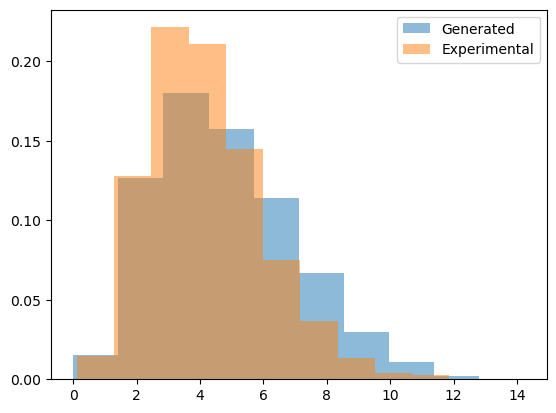

In [84]:
dist_compare.compare_specific_separation(10);#,bins=torch.arange(0,10,.05).numpy());

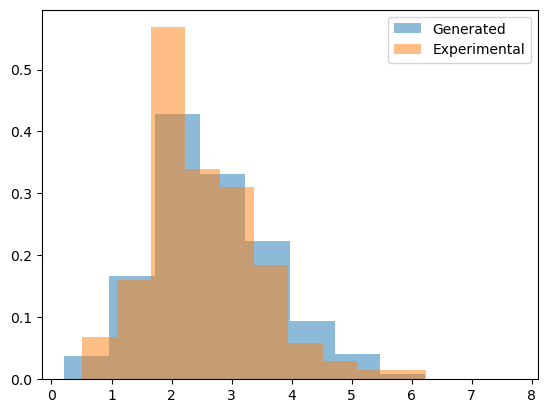

In [85]:
comparisons = dist_compare.dist_compare([(40,45),(41,45),(42,45),(43,45)],True)

#### Systematically compare guidance strengths, rescalings

In [86]:
from parse_sample_filenames import get_all_sample_types
import os
from tqdm.auto import tqdm

# Kolmogorov-Smirnov test
from scipy.stats import kstest
from scipy.stats._stats_py import KstestResult

In [87]:

sample_dir = '../../data/samples/origami_64_no_embed_reduction/'

def sample_filepath(
    sample_dir,
    region_idx,
    guidance_strength,
    rescaled_phi,
    milestone,
    chrom
):
    fp = sample_dir + f'/sample_{region_idx}_{guidance_strength}_{rescaled_phi}_{milestone}_{chrom}.pt'
    if os.path.exists(fp):
        return fp
    else:
        return fp.replace('.pt','.pkl')

def update_sample(
    dist_compare,
    sample_dir,
    region_idx,
    guidance_strength,
    rescaled_phi,
    milestone,
    chrom
):
    dist_compare.load_sample(sample_filepath(sample_dir,region_idx,guidance_strength,rescaled_phi,milestone,chrom))


def get_KS_scores(
    dist_compare,
    sample_dir,
    region_idx,
    guidance_strength,
    rescaled_phi,
    milestone,
    chrom
):
    # Update the sample we're analyzing
    dist_compare.load_sample(
        sample_filepath(sample_dir,region_idx,guidance_strength,rescaled_phi,milestone,chrom)
    )

    dist_compare.set_exp_maps(region_idx)

    # Get the set of distances associated with each interaction from both the reference (Tan) data
    # and the generated configurations
    distance_data = dist_compare.dist_compare()

    # Kolmogorov-Smirnov test for each interaction
    scores = {
        key:kstest(item[1].cpu(),item[0].cpu()) for key,item in distance_data.items()
    }
    
    return scores

def mean_score(scores_dict):
    return torch.cat([
        torch.tensor(item.statistic).reshape(1) for _,item in scores_dict.items()
    ]).mean()

def full_mean_score(scored_dict):

    if type(next(iter(scored_dict.items()))[1]) == KstestResult:
        return mean_score(scored_dict)

    temp_dict = {}
    i = 0
    for _,inner_dict in scored_dict.items():
        for _,score in inner_dict.items():
            temp_dict[i] = score
            i+= 1
    return full_mean_score(temp_dict)

def weighted_mean_score(scored_dict):
    
    stats = torch.cat([
        torch.tensor(item.statistic).reshape(1) for _,item in scored_dict.items()
    ])
    p_vals = torch.cat([
        torch.tensor(item.pvalue).reshape(1) for _,item in scored_dict.items()
    ])

    return (stats * p_vals).sum() / p_vals.sum()

def full_weighted_mean_score(scored_dict):

    if type(next(iter(scored_dict.items()))[1]) == KstestResult:
        return weighted_mean_score(scored_dict)

    temp_dict = {}
    i = 0
    for _,inner_dict in scored_dict.items():
        for _,score in inner_dict.items():
            temp_dict[i] = score
            i+= 1
    return full_weighted_mean_score(temp_dict)

def score_hist(scored_dict):

    if type(next(iter(scored_dict.items()))[1]) != KstestResult:
        temp_dict = {}
        i = 0
        for _,inner_dict in scored_dict.items():
            for _,score in inner_dict.items():
                temp_dict[i] = score
                i+= 1
        return score_hist(temp_dict)

    
    

def get_unique_scale_rescale_pairs(sample_descriptions):
    return sample_descriptions[['cond_scale','rescaled_phi']
    ].drop_duplicates(ignore_index=True)
    
def compare_all(
    dist_compare,
    sample_dir,
    **kwargs
):
    print('a')
    sample_descriptions = pd.DataFrame(
        columns = ['region_idx','cond_scale','rescaled_phi','milestone','chrom'],
        data = get_all_sample_types(sample_dir,**kwargs)
    )
    print('b')
    unique_scale_rescale_pairs = get_unique_scale_rescale_pairs(sample_descriptions)
    print('c')
    results = {}
    #for _,unique_pair in unique_scale_rescale_pairs.iterrows():
    for _,unique_pair in tqdm(unique_scale_rescale_pairs.iterrows(),desc='Outer Loop',total=len(unique_scale_rescale_pairs)):
        cs,rp = unique_pair.cond_scale, unique_pair.rescaled_phi
        
        temp_descriptions = sample_descriptions[
            (sample_descriptions.cond_scale == cs)&
            (sample_descriptions.rescaled_phi == rp)
        ]

        r = {}
        #for _,row in temp_descriptions.iterrows():
        for _,row in tqdm(temp_descriptions.iterrows(),desc='Inner Loop',total=len(temp_descriptions),leave=None):
            v = tuple(row.values)
            r[v] = get_KS_scores(dist_compare,sample_dir,*v)
            
        results[(cs,rp)] = r
    return results
    
    



In [88]:
results = compare_all(dist_compare,sample_dir,milestone=120)

a
b
c


Outer Loop:   0%|          | 0/96 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/19 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/13 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/8 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner Loop:   0%|          | 0/6 [00:00<?, ?it/s]

In [89]:
import numpy as np
def best_mean_score(means):
    a = np.array(list(map(lambda key: means[key],means)))
    best = a.min()
    idx = int(np.where(a==best)[0])
    return list(means.keys())[idx], best

Best result (0.20598213374614716) achieved with scale 0.5 and rescale 0.8


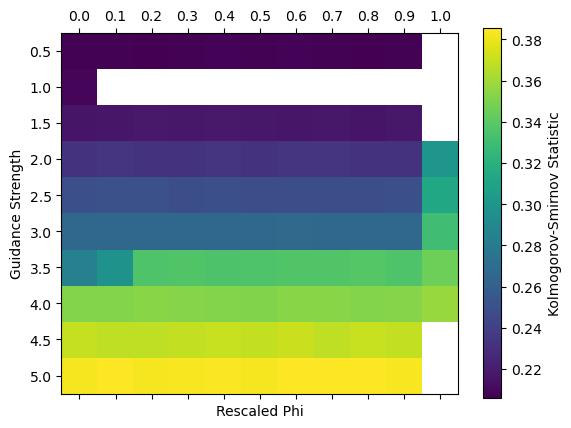

In [90]:
means = {}
for ii in results: 
    #means[ii] = full_weighted_mean_score(results[ii])
    means[ii] = full_mean_score(results[ii])
    #print(f'{ii[0]}, {ii[1]}: {means[ii]}')

cond_scales = np.unique([
    ii[0] for ii in means
])
rescaled_phis = np.unique([
    ii[1] for ii in means
])

results_2D = torch.empty(len(cond_scales),len(rescaled_phis))
results_2D[:] = torch.nan
for i,cs in enumerate(cond_scales):
    for j,rp in enumerate(rescaled_phis):
        if (cs,rp) in means: 
            results_2D[i,j] = means[(cs,rp)]

fig = plt.figure()
ax = fig.add_subplot(111) 
im = ax.matshow(results_2D)
cbar = fig.colorbar(im,label='Kolmogorov-Smirnov Statistic')

ax.set_xticks(list(range(len(rescaled_phis))))
ax.set_xticklabels([str(rp) for rp in rescaled_phis])
ax.set_yticks(list(range(len(cond_scales))))
ax.set_yticklabels([str(cs) for cs in cond_scales])

ax.set_xlabel('Rescaled Phi')
ax.set_ylabel('Guidance Strength')

(cond_scale,rescaled_phi),min_statistic = best_mean_score(means)
print(f'Best result ({min_statistic}) achieved with scale {cond_scale} and rescale {rescaled_phi}')

Best result (0.1302025957949732) achieved with scale 1.0 and rescale 0.0


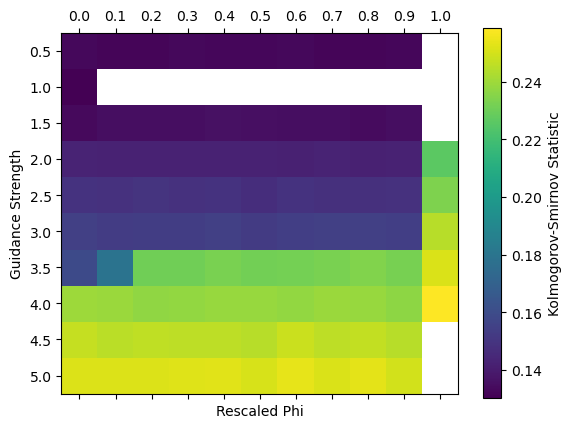

In [91]:
means = {}
for ii in results: 
    means[ii] = full_weighted_mean_score(results[ii])
    #means[ii] = full_mean_score(results[ii])
    #print(f'{ii[0]}, {ii[1]}: {means[ii]}')

import numpy as np
cond_scales = np.unique([
    ii[0] for ii in means
])
rescaled_phis = np.unique([
    ii[1] for ii in means
])

results_2D = torch.empty(len(cond_scales),len(rescaled_phis))
results_2D[:] = torch.nan
for i,cs in enumerate(cond_scales):
    for j,rp in enumerate(rescaled_phis):
        if (cs,rp) in means: 
            results_2D[i,j] = means[(cs,rp)]

fig = plt.figure()
ax = fig.add_subplot(111) 
im = ax.matshow(results_2D)
cbar = fig.colorbar(im,label='Kolmogorov-Smirnov Statistic')

ax.set_xticks(list(range(len(rescaled_phis))))
ax.set_xticklabels([str(rp) for rp in rescaled_phis])
ax.set_yticks(list(range(len(cond_scales))))
ax.set_yticklabels([str(cs) for cs in cond_scales])

ax.set_xlabel('Rescaled Phi')
ax.set_ylabel('Guidance Strength')

(cond_scale,rescaled_phi),min_statistic = best_mean_score(means)
print(f'Best result ({min_statistic}) achieved with scale {cond_scale} and rescale {rescaled_phi}')

#### Compare Guided

In [ ]:
milestone=120
from HiCDataset import HiCDataset
from HiCMap import HiCMap
exp_hic = HiCDataset()

In [ ]:
def fp(region_idx,cond_scale,rescaled_phi,milestone,chrom,save_dir):
    if region_idx == 1: 
        return save_dir + f'sample_{region_idx}_{int(cond_scale)}_{0}_{milestone}_{chrom}.pkl'
    else:
        return save_dir + f'sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'

def compare_guided_dists(
    region_idx,
    cond_scale=1,
    rescaled_phi=0,
    dist_compare=dist_compare,
    milestone=milestone,
    chrom='1',
    genomic_position=0,
    separation_list = list(range(1,segment_length,10)),
    **kwargs
):

    figs_axes = {}
    for separation in separation_list: 
        _,fig,ax = dist_compare.compare_specific_separation(separation,**kwargs)
        ax.set_xlabel('Distance')
        ax.set_ylabel('Probability Density')

        ax.set_title(
            f'Guided Generation vs Experimental Distances: {separation} Bond{"s" if separation!=1 else ""} Between Beads\n'+
            f'Chrom {chrom}: {genomic_position}-{genomic_position+segment_length*20_000}\n'+
            f'Conditional Scale: {cond_scale}; Rescaled $\\phi$: {rescaled_phi}'
        )
        figs_axes[separation] = {
            'fig':fig,
            'ax':ax
        }

    return figs_axes

def get_exp_map(region_idx,exp_hic=exp_hic,emb_idx=er.index,interp_nans=True): 

    # Get the region information from the embedding index used during sample generation
    region_length, chrom, start = emb_idx[region_idx]
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if type(sample) == Sample:
        if sample.normalized: 
            sample.unnormalize_()
        r = sample.batch.clone()
    else:
        r = sample.clone()

    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

def compare_guided(
    region_idx,
    cond_scale=1,
    rescaled_phi=0,
    dist_compare=dist_compare,
    milestone=milestone,
    chrom='1',
    sample_dir='/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami/',
    separation_list = list(range(1,segment_length,10)),
    r_c = 1.75,
    sigma = 3.5,
    threshold = 2,
    hic_approach = 'tanh',
    **kwargs
):

    dist_compare.load_sample(fp(region_idx,cond_scale,rescaled_phi,milestone,chrom,sample_dir))
    dist_compare.set_exp_maps(region_idx)
    
    _,chrom1,genomic_position = dist_compare.idx[region_idx]
    assert chrom1==chrom, f'User provided chrom {chrom}, index provided {chrom1}'

    figs_axes = compare_guided_dists(region_idx,cond_scale,rescaled_phi,dist_compare,milestone,chrom,genomic_position,separation_list,**kwargs)

    dist_compare.gen_configs.unflatten_()
    assert len(dist_compare.gen_configs.batch.shape) > 1
    if len(dist_compare.gen_configs.batch.shape) == 2:
        dist_compare.gen_configs.batch = dist_compare.gen_configs.batch.unsqueeze(0)
    if len(dist_compare.gen_configs.batch.shape) == 3:
        dist_compare.gen_configs.batch = dist_compare.gen_configs.batch.unsqueeze(1)


    
    figs_axes['HiC'] = {'Experimental':get_exp_map(region_idx)}
    if hic_approach == 'no_corrections':
        figs_axes['HiC']['Generated'] = tanh_map(dist_compare.gen_configs,r_c,sigma)
    else:
        figs_axes['HiC']['Generated'] = dist_compare.gen_configs.contact_probabilities(
            approach=hic_approach,
            r_c=r_c,
            sigma=sigma,
            threshold=threshold
        )
    
    return figs_axes

In [ ]:
fig_axes = compare_guided(144,cond_scale=.5,rescaled_phi=0,bins=50,r_c=1.75,sigma=3.5)
fig_axes['HiC']['Experimental'].plot()
fig_axes['HiC']['Generated'].plot()

In [ ]:
fig_axes = compare_guided(144,cond_scale=.5,rescaled_phi=0,bins=50,r_c=1.75,sigma=3.5,hic_approach='no_corrections')
fig_axes['HiC']['Experimental'].plot()
fig_axes['HiC']['Generated'].plot()

In [ ]:
fig_axes = compare_guided(200,cond_scale=.5,rescaled_phi=0,bins=50,r_c=1.,sigma=2,hic_approach='no_corrections')
fig_axes['HiC']['Experimental'].plot()
fig_axes['HiC']['Generated'].plot()

In [ ]:
fig_axes = compare_guided(200,cond_scale=.5,rescaled_phi=0,bins=100,r_c=1.,sigma=2,hic_approach='tanh')
fig_axes['HiC']['Experimental'].plot()
fig_axes['HiC']['Generated'].plot()

In [ ]:
#d = dist_compare.gen_configs.coords
#dists = torch.cdist(d,d) 
#tanh_map(dists,r_c=1,sigma=2).plot(vmin=3e-4)

In [ ]:
fig_axes = compare_guided(265,cond_scale=.5,rescaled_phi=0,bins=50,r_c=1.5,sigma=3,separation_list=[],hic_approach='no_corrections')
fig_axes['HiC']['Experimental'].plot()
fig_axes['HiC']['Generated'].plot()

#### Compare distance distributions for unguided case

In [ ]:
def get_many_exp_maps(dist_compare=dist_compare,region_indices=er.index,region_length=64):

    ri = region_indices
    
    chrom = ri[0][-2]
    start = ri[0][-1]
    dist_maps = [dist_compare.get_exp_maps(0)]
    i = 0 
    while i+1 < len(ri) and ri[i][-2] == chrom: 
        i+=1 
        start1 = ri[i][-1]
        if abs(start1 - start) < region_length * 20000: 
            continue

        try:
            dist_maps.append(dist_compare.get_exp_maps(i))
            start = start1
        except:
            pass # The coordinates weren't uninterrupted in the coordinate space

    return torch.cat(dist_maps,dim=0) 


In [ ]:
dist_compare.set_exp_maps(get_many_exp_maps())

In [ ]:
dist_compare.load_sample('/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/origami/sample_unguided_120.pkl')

In [ ]:
figs = {}
axes = {}
for separation in range(1,segment_length,5):
    _,fig,ax = dist_compare.compare_specific_separation(separation,bins=50)

    ax.set_xlabel('Distance')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'Unguided Distances vs Experimental: {separation} Bond{"s" if separation!=1 else ""} Between Beads')
    

In [ ]:
dist_compare.compare_specific_separation(2);

In [ ]:
asdf

In [ ]:
n_examples = {}
for k in range(len(er.index)):#range(0,1000,50):
    length,chrom_,start_idx = er.index[k]
    info,coords = config_ds.fetch_specific_coords(chrom_,start_idx)
    try:
        n_examples[k] = coords.shape[0]
    except:
        pass
    

In [ ]:
import matplotlib.pyplot as plt
x = []
y = []
for key,item in n_examples.items(): 
    x.append(key)
    y.append(item) 
plt.plot(x,y) 

In [ ]:
ymax = max(y)
best_samples = []
for sample,val in n_examples.items():
    if val == ymax:
        best_samples.append(sample)
best_samples

In [ ]:
dc = DistanceCompare(config_ds,indices=er.index) 

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from EmbeddedRegions import EmbeddedRegions
from OrigamiTransform import OrigamiTransform
from Sample import Sample
sys.path.insert(2,'../diffusion_origami/')

def is_square(mat):
    s = mat.shape
    assert len(s) > 1, f'Tensor must have at least two dimensions. Provided shape: {s}'
    return s[-1] == s[-2]

def copy_matrix_elements(from_mat,to_mat):
    assert is_square(from_mat) and is_square(to_mat), f'Both matrices must be square in the final two dimensions'

    n1,n2= from_mat.shape[-1],to_mat.shape[-1]
    n,N = min(n1,n2),max(n1,n2)

    i,j = torch.triu_indices(n,n,0)

    shift1,shift2 = max(0,n1-n2),max(0,n2-n1)
    to_mat[...,i,shift2+j] = from_mat[...,i,shift1+j]
    to_mat[...,shift2+j,i] = from_mat[...,shift1+j,i]
    

def add_diagonal(mat,diag_value=0):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'
    
    N = mat.shape[-1] + 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    i = torch.arange(N)
    new_mat[...,i,i] = diag_value

    return new_mat

def remove_diagonal(mat):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'

    N = mat.shape[-1] - 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    
    return new_mat

class Sampler: 

    def __init__(
        self,
        diffusion=None,#diffusion,
        embeddings=None,#embeddings,
        cond_scale=5.,
        rescaled_phi=0.5,
        nsamples=100
    ):

        self.diffusion = diffusion
        self.embeddings = embeddings
        self.cond_scale = cond_scale
        self.rescaled_phi = rescaled_phi
        self.nsamples = nsamples

    def __call__(
        self,
        region_index=None,
        *,
        embedding=None,
        nsamples = None,
        diffusion=None,
        embeddings=None,
        cond_scale=None,
        rescaled_phi=None
    ):
        assert (region_index is None) ^ (embedding is None), "Must pass EITHER region_index OR embedding"

        # Set the necessary options
        nsamples = self.nsamples if nsamples is None else nsamples
        diffusion = self.diffusion if diffusion is None else diffusion
        embeddings = self.embeddings if embeddings is None else embeddings
        cond_scale = self.cond_scale if cond_scale is None else cond_scale
        rescaled_phi = self.rescaled_phi if rescaled_phi is None else rescaled_phi

        # Get the desired embedding and expand it to the desired sample size
        emb = embedding if region_index is None else embeddings.iloc[region_index,0]
        emb = emb.to(diffusion.device).expand(nsamples,-1,-1,-1)

        # Sample with the diffusion model
        data = diffusion.sample(emb,cond_scale=cond_scale,rescaled_phi=rescaled_phi)

        # Reverse the origami transform
        data = origami_transform.inverse(data)

        # Remove the diagonal so that we can directly use the Sample class
        data = remove_diagonal(data) 

        # Make a Sample object
        sample = Sample(data=data)

        return sample

    def get_valid_attributes(self):
        valid_attributes = []
        for attr in dir(self): 
            if attr[0] != '_' and not callable(getattr(self, attr)): 
                valid_attributes.append(attr)
        return valid_attributes
    
    def set(self,**kwargs):
        '''
        Options: 
        diffusion
        embedded_regions
        cond_scale
        rescaled_phi
        nsamples
        '''
        assert len(kwargs) > 0, f'Expected at least one keyword argument.'
        attrs = self.get_valid_attributes()
        for attr,value in kwargs.items():
            assert attr in attrs, f'Error: Keyword argument {attr} not recognized. Valid attributes to set are: {attrs}.'
            assert (getattr(self,attr) is None) or type(value) == type(getattr(self,attr)), f'Expected type {type(getattr(self,attr))} for attribute {attr}, but received {type(value)}.'
        for attr, value in kwargs.items():
            setattr(self, attr, value)

def get_dist_env():
    if 'OMPI_COMM_WORLD_SIZE' in os.environ:
        world_size = int(os.getenv('OMPI_COMM_WORLD_SIZE'))
    else:
        world_size = int(os.getenv('SLURM_NTASKS'))

    if 'OMPI_COMM_WORLD_RANK' in os.environ:
        global_rank = int(os.getenv('OMPI_COMM_WORLD_RANK'))
    else:
        global_rank = int(os.getenv('SLURM_PROCID'))
    return global_rank, world_size

if __name__ == "__main__":

    ############################################
    # Parallelization stuff
    ############################################
    from torch.nn.parallel import DistributedDataParallel as DDP
    import torch.distributed as dist
    import socket
    
    global_rank, world_size = get_dist_env()
    hostname = socket.gethostname()
    # You have run dist.init_process_group to initialize the distributed environment
    # Always use NCCL as the backend. Gloo performance is pretty bad and MPI is currently
    # unsupported (for a number of reasons).
    dist.init_process_group(backend='nccl', rank=global_rank, world_size=world_size)

    # Set the cuda devices to avoid duplicate device in nccl
    torch.cuda.set_device(global_rank%2)
    ############################################

    #import sys
    #sys.path.insert('./')
    from classifier_free_guidance_greg import Unet, GaussianDiffusion

    chroms = ['1','X']
    segment_length = 64
    c,image_size = 2,segment_length//2
    cond_scales = [5.]
    rescaled_phis = [.5]
    nsamples = 1000

    # All of these regions have 30 structures (EXCLUDING replicates) in chrom 1, while 
    # the chrom X regions have 32 structures for comparison (16 cells, mat/pat chromosomes) 
    regions_dict = {
        '1':[144,200,265,330,395,460,525,590,730,795,860,1260,1325],
        'X':[100,236,381,445,553,610,675,810,900,965,1060,1125,1200]
    }

    #### 
    model_folder = '../../data/models/diffusion_small_origami'#'./results_small'
    config_fp = '../../data/processed_data.hdf5'
    #embedding_dir = '../../data/embeddings/'
    embedding_dir = '../../data/embeddings_hg19_via_hg38_params/'
    mean_dist_fp = '../../data/mean_dists.pt'
    mean_sq_dist_fp='../../data/squares.pt'
    save_dir = '../../data/samples/origami/'
    ###

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def fp(region_idx,cond_scale,rescaled_phi,milestone,chrom,save_dir=save_dir):
        return save_dir + f'sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'

    def get_existing_sample(filepath):
        if os.path.exists(filepath):
            sample = pd.read_pickle(filepath)
            sample = Sample(data = sample.unflatten())
            return sample
        else:
            return None

    def save_sample(sample,filepath):

        sample1 = get_existing_sample(filepath)
        if sample1 is not None: 
            data1 = sample1.unflatten().to(device=sample.device,dtype=sample.dtype)
            if len(data1.shape) < 3: 
                data1 = data1.unsqueeze(0)
            data2 = sample.unflatten()
            if len(data2.shape) < 3: 
                data2 = data2.unsqueeze(0)

            data = torch.cat((data1,data2),dim=0)
            sample = Sample(data=data)
            
        pickle.dump(sample,open(filepath,'wb'))

    def get_nsamples(filepath,nsamples=nsamples):
        sample = get_existing_sample(filepath)
        if sample is None:
            return nsamples
        return max(0,nsamples-len(sample))

    def load_most_recent_milestone(diffusion,folder):

        if folder != '' and folder[-1] != '/': 
            folder = folder + '/'
    
        files = os.listdir(folder)
        milestone = 0 
        file = ''
        for f in files: 
            m = int('.'.join(f.split('.')[:-1]).split('-')[-1])
            if m > milestone: 
                milestone = m
                file = f
        
        diffusion.load(folder + file)
    
        return milestone
    
    # Initializing model
    print('Initializing model',flush=True)
    model = Unet(
        dim=64,
        cond_drop_prob = 0.5,
        init_dim = None,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = c,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        attn_dim_head = 32,
        attn_heads = 4,
        embedding_dimensions=(1,260,256)#tuple(er.ifetch(0)[0].shape)
    ).to(f'cuda:{global_rank%2}')
    
    diffusion = GaussianDiffusion(
        model,
        image_size=image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'cosine',
        ddim_sampling_eta = 1.,
        offset_noise_strength = 0.,
        min_snr_loss_weight = False,
        min_snr_gamma = 5
    ).to(f'cuda:{global_rank%2}')


    # Loading most recent model parameters
    print('Loading model parameters',flush=True)
    milestone = load_most_recent_milestone(diffusion,model_folder) 
    
    ####### ALLOW THE NETWORK TO RUN ON GPUS IN PARALLEL ##############
    # % 2 because each node has 2 gpus locally referred to as 0 & 1
    diffusion = DDP(diffusion, device_ids=[global_rank%2], output_device=None)
    ###################################################################

    # Loading embeddings
    print('Loading embeddings',flush=True)
    embeddings_dict = {}
    for chrom in chroms:
        embeddings_dict[chrom] = pd.read_pickle(f'{embedding_dir}/chrom_{chrom}.tar.gz')

    # Preparing Sampler
    print('Preparing Sampler',flush=True)
    sampler = Sampler(diffusion=diffusion)

    # Sample loop
    print('Sampling Loop',flush=True)
    for chrom in chroms: 
        regions = regions_dict[chrom]
        embeddings = embeddings_dict[chrom]

        sampler.set(embeddings=embeddings)
        
        for cond_scale in cond_scales: 
            sampler.set(cond_scale=cond_scale)
            rescaled_phis1 = rescaled_phis if cond_scale != 1 else [0]
            for rescaled_phi in rescaled_phis1: 
                sampler.set(rescaled_phi=rescaled_phi)
                for region_idx in regions:
                    # Get the relevant filepath
                    f = fp(region_idx,cond_scale,rescaled_phi,milestone,chrom)

                    # If some samples already exist, see how many more must be produced to obtain the desired
                    # number of total samples. 
                    nsamples_still_needed = get_nsamples(f,nsamples)

                    # Generate those samples
                    sample = sampler(region_idx,nsamples=nsamples_still_needed)

                    # Save the sample 
                    save_sample(sample,f) 